<a href="https://colab.research.google.com/github/jhhan0/self-study-ml/blob/main/tutorials/image-segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation
- Demonstrates how to do image segmentation, a task to find the shape of specific object in the input image and then, to assign a class to each pixel of image. Each pixel is given one of three sets: (1, pixel belongs to the pet), (2, pixel bordering the pet) and (3, pixel in surrounding)
- Full tutorial reference: https://www.tensorflow.org/tutorials/images/segmentation 


In [1]:
pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-_jqnz0ka
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-_jqnz0ka
  Resolved https://github.com/tensorflow/examples.git to commit 37df0b9a2f7240831642cea4380e4f7ec33bee83
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-37df0b9a2f7240831642cea4380e4f7ec33bee83_-py3-none-any.whl size=299718 sha256=4774910156306005935fef7fd4f38a0daa7b0c438a3efaa65511dfb26bda93bb
  Stored in directory: /tmp/pip-ephem-wheel-cache-g_og_3x2/wheels/4e/f5/c2/bfe75b834c9028b2529023bf74541c46ead531b513a8010d21
Failed to build tensorflow-examples
  Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel c

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.11.0


Download the Oxford-IIIT Pets Dataset from TensorFlow Datasets. 

In [3]:
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete7FM1MB/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete7FM1MB/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


Define a function to normalize the image color values to the [0, 1] range. In addition, label the segmentation mask to {0, 1, 2} by subtracting 1 from the original {1, 2, 3} for ease of handling.

In [4]:
def normalize(image, mask):
  image = tf.cast(image, tf.float32) / 255.0
  mask -= 1
  return image, mask

In [16]:
IMAGE_SIZE = 128
def load(data):
  image = tf.image.resize(data['image'], (IMAGE_SIZE, IMAGE_SIZE))
  mask = tf.image.resize(data['segmentation_mask'], (IMAGE_SIZE, IMAGE_SIZE), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  label = data['label']
  image, mask = normalize(image, mask)
  return image, mask, label

In [11]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    sp

In [17]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [18]:
train_ds = dataset['train'].map(load, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = dataset['test'].map(load, num_parallel_calls=tf.data.AUTOTUNE)

Perform a simple data augmentation.

In [46]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=12):
    super().__init__()
    self.images = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.masks = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, images, masks, labels):
    images = self.images(images)
    masks = self.masks(masks)
    return images, masks, labels

In [47]:
train_batches = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().map(Augment()).prefetch(buffer_size=tf.data.AUTOTUNE)
test_batches = test_ds.batch(BATCH_SIZE)

In [48]:
get_label_name = info.features['label'].int2str

english_cocker_spaniel


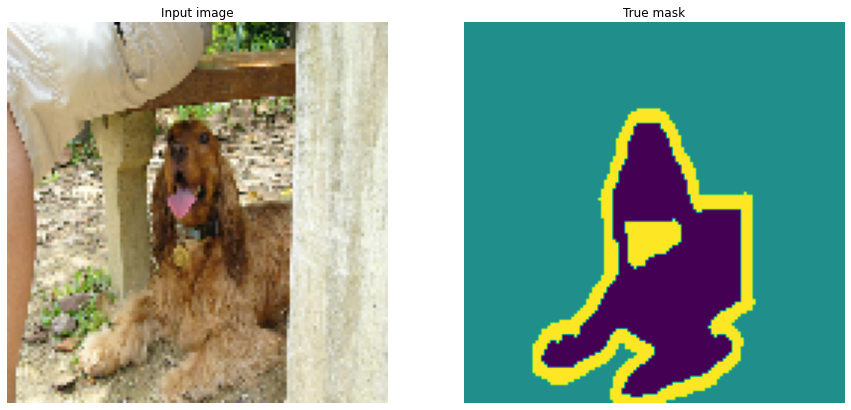

Bengal


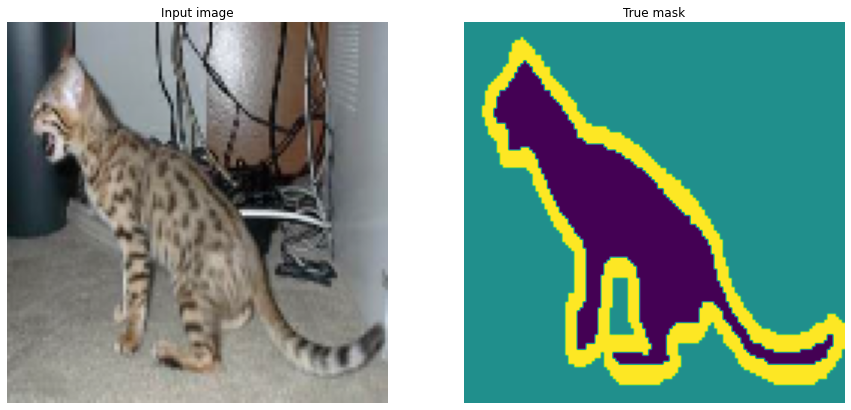

staffordshire_bull_terrier


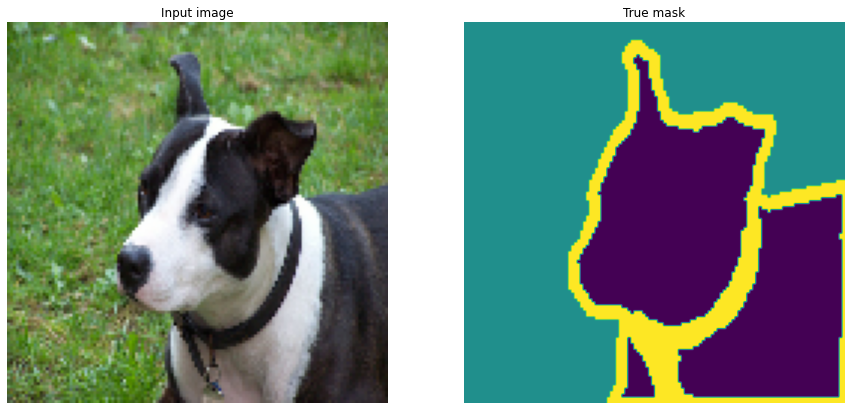

In [49]:
for images, masks, labels in train_batches.take(1):
  for i in range(3):
    plt.figure(figsize=(15, 15))
    image, mask, label = images[i], masks[i], labels[i]
    print(get_label_name(label))
    plt.subplot(1, 2, 1)
    plt.title('Input image')
    plt.imshow(tf.keras.utils.array_to_img(image))
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('True mask')
    plt.imshow(tf.keras.utils.array_to_img(mask))
    plt.axis('off')
    plt.show()

Define the model